# Identify underperforming crops from the provided raster dataset.


**Band 3**: Crop type predictions.

**Band 4**: Model confidence scores for Band 3.

In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm, ListedColormap
from rasterio.mask import mask
from rasterio.vrt import WarpedVRT
from rasterio.warp import Resampling
from shapely.geometry import Polygon, box

from src.common.utils import get_utm_zone_epsg
from src.constants import (
    CROP_TYPE_PREDICTION_CONFIDENCE_BAND,
    CROP_TYPE_PREDICTION_INDEX_BAND,
    LABELS_INDEX,
    MISSING_VALUE,
    TWO_WAY_LABELS_DICT,
)

## u0e

In [2]:
u0e_analysis = gpd.read_file('/code/support_files/u0e_gt_model_example.gpkg')
u0e_analysis

,field_id,area_m2,normalized_label,year,majority_crop,confidence_score,majority_crop_label,gt_label,gt_ml_match,geometry
0,3b3a7827-6149-4733-951b-eae1d65c5ff2,2871.587981,barley_spring,2022,28.0,53.750000,Fallow,Spring Barley,0,"POLYGON ((4.29005 48.82525, 4.2898 48.82555, 4..."
1,4b0b7266-62df-4a29-939c-fb757c965351,90370.992230,barley_spring,2022,6.0,48.722222,Spring Barley,Spring Barley,1,"POLYGON ((4.27618 48.96187, 4.27595 48.96174, ..."
2,db51efee-b88c-4611-b9e5-db029ef4560a,14131.292570,barley_spring,2022,5.0,52.857143,Winter Barley,Spring Barley,0,"POLYGON ((4.22832 48.65064, 4.21998 48.6477, 4..."
3,5c309910-7dea-410b-8756-a579b0906976,22592.181240,barley_spring,2022,5.0,55.558824,Winter Barley,Spring Barley,0,"POLYGON ((4.30365 48.99449, 4.30199 48.99337, ..."
4,2f7d55c3-33bb-4e3c-962f-e697ae2a6b9d,36978.161367,barley_spring,2022,6.0,47.627907,Spring Barley,Spring Barley,1,"POLYGON ((4.25154 49.09641, 4.25068 49.1045, 4..."
...,...,...,...,...,...,...,...,...,...,...
70,db54de67-c7d6-4760-8f06-7946b079f597,61250.037319,barley_spring,2022,5.0,36.625000,Winter Barley,Spring Barley,0,"POLYGON ((4.23295 48.69991, 4.23314 48.70016, ..."
71,da83fe95-fd9a-4e6d-a2d9-ce5546de6a6d,96006.025520,barley_spring,2022,6.0,69.794702,Spring Barley,Spring Barley,1,"POLYGON ((4.25093 49.00886, 4.25077 49.00845, ..."
72,a34709e8-3193-4971-946c-2fc4eba72f80,24308.217631,barley_spring,2022,5.0,49.884615,Winter Barley,Spring Barley,0,"POLYGON ((4.31396 49.03012, 4.31467 49.03019, ..."
73,508c042c-8c1c-4e7e-8926-40f648929e3d,44889.804598,barley_spring,2022,6.0,48.534884,Spring Barley,Spring Barley,1,"POLYGON ((4.31371 49.0336, 4.31396 49.03368, 4..."


In [3]:
len(u0e_analysis['majority_crop'].unique())

5

In [4]:
u0e_performance = pd.read_csv('/code/support_files/u0e_gt_crop_and_crop_confidence_fr.csv')
u0e_performance

,crop,num_fields,agreement_score,weighted_f1_score
0,Canola,4547,0.99,1.00
1,Vineyard,2848,0.98,0.99
2,Sugarbeets,2343,0.97,0.99
3,Winter Wheat,17057,0.97,0.98
4,Potatoes,359,0.95,0.98
5,Winter Barley,6798,0.94,0.97
6,Sunflowers,3287,0.92,0.96
7,Silage Corn,2125,0.86,0.93
8,Lentils,503,0.87,0.93
9,Alfalfa,4435,0.86,0.92


**performance was on 29 classes**

## u0c

In [5]:
! gdalinfo /code/data/ml_2021-08-01_2022-12-31_u0c.tif

Driver: GTiff/GeoTIFF
Files: /code/data/ml_2021-08-01_2022-12-31_u0c.tif
Size is 5429, 5361
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.

**ml_2021-08-01_2022-12-31_u0c.tif represents the inference outputs**

In [6]:
model_prediction_ds = rasterio.open("/code/data/ml_2021-08-01_2022-12-31_u0c.tif")
predictions = model_prediction_ds.read(CROP_TYPE_PREDICTION_INDEX_BAND)
confidence = model_prediction_ds.read(CROP_TYPE_PREDICTION_CONFIDENCE_BAND)
len(np.unique(predictions))

28

In [7]:
confidence

array([[74, 75, 73, ..., 42, 62, 51],
       [75, 72, 75, ..., 83, 84, 56],
       [73, 75, 77, ..., 83, 81, 45],
       ...,
       [33, 28, 21, ..., 92, 92, 93],
       [35, 36, 35, ..., 91, 93, 93],
       [28, 23, 37, ..., 92, 92, 93]], shape=(5361, 5429), dtype=int16)

In [8]:
predictions.max()

np.int16(31)

**Check which classes the model made / did not make a prediction for**

In [9]:
pred_class_count = dict()
for pred_idx, pred_class in enumerate(LABELS_INDEX):
    n_pred_for_class = predictions.flatten() == pred_idx
    n_pix_pred = np.sum(n_pred_for_class)
    pred_class_count[pred_class] = n_pix_pred
    if n_pix_pred == 0:
        print(f"Model did not predict any pixels were {pred_idx}/{pred_class}")

Model did not predict any pixels were 9/Winter Rye
Model did not predict any pixels were 10/Spring Rye
Model did not predict any pixels were 26/Beans
Model did not predict any pixels were 29/Turnips


## ground truth for u0c validation region

In [10]:
ground_truth = gpd.read_file("/code/data/u0c_gt_filtered_2022.gpkg")
ground_truth['label'] = ground_truth['normalized_label'].apply(lambda x: TWO_WAY_LABELS_DICT.get(x, MISSING_VALUE))
valid_labels = ground_truth[ground_truth['label'] != MISSING_VALUE]
discarded_labels = ground_truth[ground_truth['label'] == MISSING_VALUE]

valid_labels.loc[valid_labels.index, ['label_index']] = valid_labels['label'].apply(lambda x: LABELS_INDEX.index(x))

valid_labels = valid_labels.reset_index(drop=True)
valid_labels = valid_labels.reset_index()
valid_labels

,index,field_id,area_m2,normalized_label,year,geometry,label,label_index
0,0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.39478, 1.6807 49.39475, 1...",Vineyard,31.0
1,1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.53424 49.52747, 1.53498 49.5276, 1...",Vineyard,31.0
2,2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.73154, 2.28695 49.73236, ...",Vineyard,31.0
3,3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.28609 49.73127, 2.28555 49.73223, ...",Vineyard,31.0
4,4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.86942 50.25858, 1.8701 50.25966, 1...",Vineyard,31.0
...,...,...,...,...,...,...,...,...
153857,153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.82623 49.35807, 1.82604 49.35806, ...",Millet,13.0
153858,153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.80245 49.34628, 1.80238 49.34602, ...",Millet,13.0
153859,153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.81285 49.34484, 1.81309 49.34531, ...",Millet,13.0
153860,153860,113047e0-ee04-44cb-b087-04a1206df177,3030.348612,millet,2022,"POLYGON ((1.81156 49.34383, 1.81155 49.34381, ...",Millet,13.0


In [11]:
len(valid_labels['field_id'].unique())

153862

In [12]:
np.unique([str(v.__class__) for v in valid_labels.geometry])

array(["<class 'shapely.geometry.collection.GeometryCollection'>",
       "<class 'shapely.geometry.multipolygon.MultiPolygon'>",
       "<class 'shapely.geometry.polygon.Polygon'>"], dtype='<U56')

In [13]:
discarded_labels

,field_id,area_m2,normalized_label,year,geometry,label
42305,f2ef7379-925a-423a-b864-3bb1c67585c8,14687.123217,radish,2022,"POLYGON ((2.03236 49.65503, 2.03262 49.65476, ...",MISSING_VALUE
42306,9292b58a-18a3-4920-a3c2-2dc676900767,11536.496491,radish,2022,"POLYGON ((2.44639 49.6617, 2.44601 49.66398, 2...",MISSING_VALUE


In [14]:
valid_labels

,index,field_id,area_m2,normalized_label,year,geometry,label,label_index
0,0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.39478, 1.6807 49.39475, 1...",Vineyard,31.0
1,1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.53424 49.52747, 1.53498 49.5276, 1...",Vineyard,31.0
2,2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.73154, 2.28695 49.73236, ...",Vineyard,31.0
3,3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.28609 49.73127, 2.28555 49.73223, ...",Vineyard,31.0
4,4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.86942 50.25858, 1.8701 50.25966, 1...",Vineyard,31.0
...,...,...,...,...,...,...,...,...
153857,153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.82623 49.35807, 1.82604 49.35806, ...",Millet,13.0
153858,153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.80245 49.34628, 1.80238 49.34602, ...",Millet,13.0
153859,153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.81285 49.34484, 1.81309 49.34531, ...",Millet,13.0
153860,153860,113047e0-ee04-44cb-b087-04a1206df177,3030.348612,millet,2022,"POLYGON ((1.81156 49.34383, 1.81155 49.34381, ...",Millet,13.0


In [15]:
prediction_path = '/code/data/ml_2021-08-01_2022-12-31_u0c.tif'

with rasterio.open(prediction_path) as src:
    predictions = src.read(3)
    confidence = src.read(4)
    # NOTE: Below should not be done in WGS84
    shapes = [
        (valid_labels['geometry'].loc[idx], valid_labels['label_index'].loc[idx])
        for idx in valid_labels.index
    ]
    rasterized_labels = rasterio.features.rasterize(
        shapes=shapes, out_shape=src.shape, transform=src.transform, nodata=255
    )
    shapes = [
        (valid_labels['geometry'].loc[idx], valid_labels['index'].loc[idx])
        for idx in valid_labels.index
    ]
    rasterized_field_indices = rasterio.features.rasterize(
        shapes=shapes, out_shape=src.shape, transform=src.transform, nodata=255
    )


In [16]:
pixel_df = pd.DataFrame(
    {
        "field_index": rasterized_field_indices.flatten(),
        "label_value": rasterized_labels.flatten(),
        "predictions": predictions.flatten(),
        "confidence": confidence.flatten(),
    }
)
pixel_df.groupby('field_index').count()

,label_value,predictions,confidence
field_index,,,
0,20250888,20250888,20250888
1,7,7,7
2,22,22,22
3,25,25,25
4,19,19,19
...,...,...,...
153857,3,3,3
153858,8,8,8
153859,6,6,6


In [17]:
field_df_mean = pixel_df.groupby("field_index").mean()
field_df_mode = pixel_df.groupby("field_index").mean()
field_df_mean

,label_value,predictions,confidence
field_index,,,
0,0.000014,16.597771,56.649625
1,31.000000,28.000000,29.714286
2,31.000000,28.681818,51.227273
3,31.000000,28.720000,41.000000
4,31.000000,28.473684,45.000000
...,...,...,...
153857,13.000000,27.666667,46.666667
153858,13.000000,22.125000,23.500000
153859,13.000000,28.666667,47.833333


In [18]:
field_df_mean = pd.read_csv("/code/field_df_mean.csv")
field_df_mode = pd.read_csv("/code/field_df_mode.csv")
field_df_count = pd.read_csv("/code/field_df_count.csv")

main_df = (
    valid_labels.set_index("index")
    .join(
        field_df_mode[["field_index", "label_value", "predictions"]].set_index(
            "field_index"
        )
    )
    .join(field_df_mean[["field_index", "confidence"]].set_index("field_index"))
    .join(
        field_df_count[["field_index", "label_value"]]
        .set_index("field_index")
        .rename(columns={"label_value": "n_pixels"})
    )
)
main_df

,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels
index,,,,,,,,,,,
0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.39478, 1.6807 49.39475, 1...",Vineyard,31.0,31.0,22,35.000000,9.0
1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.53424 49.52747, 1.53498 49.5276, 1...",Vineyard,31.0,31.0,28,29.714286,7.0
2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.73154, 2.28695 49.73236, ...",Vineyard,31.0,31.0,31,51.227273,22.0
3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.28609 49.73127, 2.28555 49.73223, ...",Vineyard,31.0,31.0,31,41.000000,25.0
4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.86942 50.25858, 1.8701 50.25966, 1...",Vineyard,31.0,31.0,31,45.000000,19.0
...,...,...,...,...,...,...,...,...,...,...,...
153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.82623 49.35807, 1.82604 49.35806, ...",Millet,13.0,13.0,31,46.666667,3.0
153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.80245 49.34628, 1.80238 49.34602, ...",Millet,13.0,13.0,28,23.500000,8.0
153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.81285 49.34484, 1.81309 49.34531, ...",Millet,13.0,13.0,31,47.833333,6.0


In [20]:
main_df = pd.read_csv("/code/main_df.csv")
main_df

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels
0,0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.394782, 1.680697 49.39475...",Vineyard,31,31.0,22,35.000000,9.0
1,1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.534244 49.52747, 1.534975 49.52760...",Vineyard,31,31.0,28,29.714286,7.0
2,2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.731536, 2.286951 49.73235...",Vineyard,31,31.0,31,51.227273,22.0
3,3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.286092 49.731274, 2.285546 49.7322...",Vineyard,31,31.0,31,41.000000,25.0
4,4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.869418 50.25858, 1.870102 50.25965...",Vineyard,31,31.0,31,45.000000,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
153857,153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.826233 49.358066, 1.82604 49.35806...",Millet,13,13.0,31,46.666667,3.0
153858,153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.802453 49.346277, 1.802382 49.3460...",Millet,13,13.0,28,23.500000,8.0
153859,153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.812849 49.344839, 1.813091 49.3453...",Millet,13,13.0,31,47.833333,6.0
153860,153860,113047e0-ee04-44cb-b087-04a1206df177,3030.348612,millet,2022,"POLYGON ((1.811558 49.343832, 1.811549 49.3438...",Millet,13,13.0,[22 28 31],28.000000,3.0


# Determine underperforming crops

<Axes: xlabel='normalized_label'>

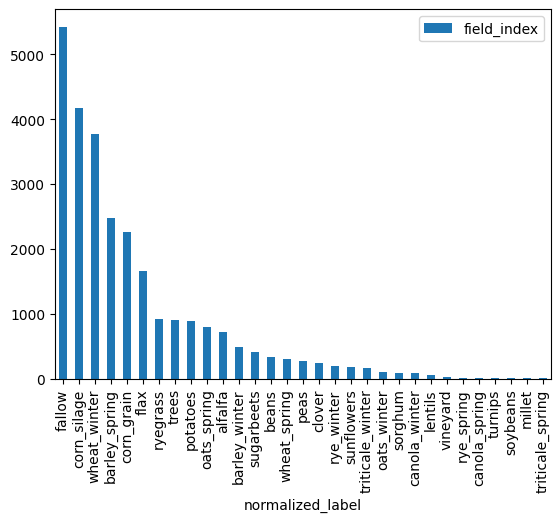

In [57]:
def clean_predictions(p):
    try:
        return int(p)
    except ValueError:
        return p
        
main_df['predictions_clean'] = main_df['predictions'].apply(lambda x: clean_predictions(x))
misclassified_fields = main_df[main_df['label_index'] != main_df['predictions_clean']]
misclassified_field_counts = misclassified_fields.groupby('normalized_label').count()
misclassified_field_counts.reset_index().sort_values('field_index', ascending=False).plot.bar(x='normalized_label', y='field_index')

In [50]:
misclassidied_field_counts.reset_index()

,normalized_label,field_index,field_id,area_m2,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels,predictions_clean
0,alfalfa,713,713,713,713,713,713,713,711,711,711,711,711
1,barley_spring,2483,2483,2483,2483,2483,2483,2483,2475,2475,2475,2475,2475
2,barley_winter,481,481,481,481,481,481,481,459,459,459,459,459
3,beans,336,336,336,336,336,336,336,336,336,336,336,336
4,canola_spring,12,12,12,12,12,12,12,12,12,12,12,12
5,canola_winter,91,91,91,91,91,91,91,79,79,79,79,79
6,clover,239,239,239,239,239,239,239,238,238,238,238,238
7,corn_grain,2255,2255,2255,2255,2255,2255,2255,2242,2242,2242,2242,2242
8,corn_silage,4166,4166,4166,4166,4166,4166,4166,4151,4151,4151,4151,4151
9,fallow,5424,5424,5424,5424,5424,5424,5424,5381,5381,5381,5381,5381


In [46]:
misclassidied_field_counts

,field_index,field_id,area_m2,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels,predictions_clean
normalized_label,,,,,,,,,,,,
alfalfa,713,713,713,713,713,713,713,711,711,711,711,711
barley_spring,2483,2483,2483,2483,2483,2483,2483,2475,2475,2475,2475,2475
barley_winter,481,481,481,481,481,481,481,459,459,459,459,459
beans,336,336,336,336,336,336,336,336,336,336,336,336
canola_spring,12,12,12,12,12,12,12,12,12,12,12,12
canola_winter,91,91,91,91,91,91,91,79,79,79,79,79
clover,239,239,239,239,239,239,239,238,238,238,238,238
corn_grain,2255,2255,2255,2255,2255,2255,2255,2242,2242,2242,2242,2242
corn_silage,4166,4166,4166,4166,4166,4166,4166,4151,4151,4151,4151,4151


In [22]:
main_df[~(main_df['label_index'] == main_df['label_value'])]

,field_index,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels
69,69,8f3df8d3-ec1d-4cdc-8919-977e6a5ebf1c,2315.003032,trees,2022,"POLYGON ((2.338237 50.051964, 2.33759 50.05188...",Trees,30,NaN,NaN,NaN,NaN
172,172,55c2781d-c0c5-4bf9-a2fa-53a655cbdb4e,41716.844739,trees,2022,"POLYGON ((1.766063 49.342584, 1.766344 49.3425...",Trees,30,NaN,NaN,NaN,NaN
179,179,1ac75cbf-4f3c-4587-9f19-abfcef8439b7,65256.593342,trees,2022,"POLYGON ((1.766791 49.347913, 1.766973 49.3475...",Trees,30,NaN,NaN,NaN,NaN
188,188,6157b68b-68b2-4b09-bb57-7f11c8c58a48,34413.803483,trees,2022,"POLYGON ((1.771068 49.339523, 1.770466 49.3397...",Trees,30,NaN,NaN,NaN,NaN
207,207,7ae594d0-5a8c-43cb-a1f2-34f05eca32ca,50842.422367,trees,2022,"POLYGON ((1.76652 49.339598, 1.767173 49.33965...",Trees,30,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
140032,140032,5f31aece-e5e6-4a75-9932-3cc1950f9ac7,9374.718606,barley_winter,2022,"POLYGON ((2.789048 49.592813, 2.793745 49.5928...",Winter Barley,5,NaN,NaN,NaN,NaN
147520,147520,fb62c878-f25c-44e0-bb40-83d4b4330d30,3799.729195,sugarbeets,2022,"POLYGON ((2.432202 50.609019, 2.432292 50.6090...",Sugarbeets,23,NaN,NaN,NaN,NaN
151663,151663,f1fe1639-777b-4c11-b34e-80daeb5f737f,20945.741097,peas,2022,"POLYGON ((1.731693 49.227813, 1.731778 49.2278...",Peas,25,NaN,NaN,NaN,NaN
151664,151664,875094ed-ad88-4020-981b-153b9762a7ad,25236.231436,peas,2022,"POLYGON ((1.730784 49.229279, 1.728488 49.2295...",Peas,25,NaN,NaN,NaN,NaN


In [5]:
field_df_mode[['field_index', 'label_value', 'predictions']]

,field_index,label_value,predictions
0,0,0,28
1,1,31,28
2,2,31,31
3,3,31,31
4,4,31,31
...,...,...,...
153652,153857,13,31
153653,153858,13,28
153654,153859,13,31
153655,153860,13,[22 28 31]


In [6]:
field_df_mean[['field_index', 'confidence']]

,field_index,confidence
0,0,56.649625
1,1,29.714286
2,2,51.227273
3,3,41.000000
4,4,45.000000
...,...,...
153652,153857,46.666667
153653,153858,23.500000
153654,153859,47.833333
153655,153860,28.000000


In [10]:
field_df_count[['field_index', 'label_value']]

,field_index,label_value
0,0,20250888
1,1,7
2,2,22
3,3,25
4,4,19
...,...,...
153652,153857,3
153653,153858,8
153654,153859,6
153655,153860,3


In [22]:
valid_labels.set_index("index").join(
    field_df_mode[["field_index", "label_value", "predictions"]].set_index(
        "field_index"
    )
).join(
    field_df_mean[["field_index", "confidence"]].set_index(
        "field_index"
    )
).join(
    field_df_count[["field_index", "label_value"]].set_index("field_index").rename(columns={"label_value": "n_pixels"})
)


,field_id,area_m2,normalized_label,year,geometry,label,label_index,label_value,predictions,confidence,n_pixels
index,,,,,,,,,,,
0,0b6947ad-48c3-4d4e-8180-0c5511d53cfa,4725.570410,vineyard,2022,"POLYGON ((1.68069 49.39478, 1.6807 49.39475, 1...",Vineyard,31.0,0.0,28,56.649625,20250888.0
1,ce190383-0a9c-4e07-babd-84231bca342f,3977.850757,vineyard,2022,"POLYGON ((1.53424 49.52747, 1.53498 49.5276, 1...",Vineyard,31.0,31.0,28,29.714286,7.0
2,509fd0e1-1a5b-4c18-9c34-ac3f92e250b6,12203.754334,vineyard,2022,"POLYGON ((2.28742 49.73154, 2.28695 49.73236, ...",Vineyard,31.0,31.0,31,51.227273,22.0
3,2f01fe6b-289d-45c0-976e-1c870921411f,14456.984724,vineyard,2022,"POLYGON ((2.28609 49.73127, 2.28555 49.73223, ...",Vineyard,31.0,31.0,31,41.000000,25.0
4,e5b80722-6b71-4925-a3b9-b72c295da63c,10264.691558,vineyard,2022,"POLYGON ((1.86942 50.25858, 1.8701 50.25966, 1...",Vineyard,31.0,31.0,31,45.000000,19.0
...,...,...,...,...,...,...,...,...,...,...,...
153857,9e4331b3-7626-4cdb-9a23-a921c96b66e4,2816.240225,millet,2022,"POLYGON ((1.82623 49.35807, 1.82604 49.35806, ...",Millet,13.0,13.0,31,46.666667,3.0
153858,454bac96-a987-41fa-891e-7d6fc2bd0dab,4968.793841,millet,2022,"POLYGON ((1.80245 49.34628, 1.80238 49.34602, ...",Millet,13.0,13.0,28,23.500000,8.0
153859,1c7585ca-3330-4328-b203-ffd4c484c965,4661.246860,millet,2022,"POLYGON ((1.81285 49.34484, 1.81309 49.34531, ...",Millet,13.0,13.0,31,47.833333,6.0


In [17]:
field_df_count[["field_index", "label_value"]].set_index("field_index").rename(columns={"label_value": "n_pixels"})

,n_pixels
field_index,
0,20250888
1,7
2,22
3,25
4,19
...,...
153857,3
153858,8
153859,6


In [ ]:
len(np.unique(rasterized_field_indices))

In [ ]:
label_bounds = gpd.GeoDataFrame(geometry=[polygon_from_bounds(valid_labels_utm.unary_union.bounds)])

from rasterio.errors import WindowError

def read_one_poly(path, gdf):
    with rasterio.open(path) as src:
        vrt_options = {
            'resampling': Resampling.nearest, 
            'crs': gdf.crs,
            'nodata': 255
        }
        
        with WarpedVRT(src, **vrt_options) as vrt:
            try:
                chunk, transform = mask(vrt, [gdf.geometry], crop=True)
            except (WindowError, ValueError):
                return None, None
                
        return chunk, transform

for idx in range(len(valid_labels_utm)):
    pixels = read_one_poly('/code/data/ml_2021-08-01_2022-12-31_u0c.tif', valid_labels_utm.iloc[[idx]])
    if pixels[0] is not None:
        break
        
pixels

In [ ]:
from rasterio.errors import WindowError
from tqdm import tqdm
from rasterio import features
idx = 1

def polygon_from_bounds(bounds):
    if isinstance(bounds, Polygon):
        return bounds
    shp = box(bounds[0], bounds[1], bounds[2], bounds[3])

    return shp
    
for idx in range(10):
    with rasterio.open('/code/data/ml_2021-08-01_2022-12-31_u0c.tif') as src:
        geom = valid_labels.buffer(0).iloc[[idx]].geometry
        gdf = gpd.GeoDataFrame(geometry=[polygon_from_bounds(src.bounds), polygon_from_bounds(geom.union_all().bounds)])
        #gdf.centroid.plot()
    
        chunk, transform = rasterio.mask.mask(src, geom.buffer(0), crop=True)
        if len(np.unique(chunk)) > 1:
            break

chunk

In [ ]:
with rasterio.open('/code/data/ml_2021-08-01_2022-12-31_u0c.tif') as src:
    geom = valid_labels.buffer(0).geometry
    chunk, transform = rasterio.mask.mask(src, geom, crop=True)

chunk

In [19]:
shapes = [
    (valid_labels['geometry'].loc[idx],
    valid_labels['label_index'].loc[idx]) for idx in valid_labels.index
]
with rasterio.open('/code/data/ml_2021-08-01_2022-12-31_u0c.tif') as src:
    predictions = src.read(3)
    confidence = src.read(4)
    rasterized_labels = features.rasterize(
        shapes=shapes, out_shape=src.shape, transform=src.transform, nodata=255
    )


In [20]:
result = np.concat([np.expand_dims(predictions,2) , np.expand_dims(confidence, 2), np.expand_dims(rasterized_labels,2)], axis=2)

In [22]:
np.unique(rasterized_labels)

array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31.])

In [23]:
np.unique(predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 27, 28, 30, 31], dtype=int16)

In [24]:
from sklearn.metrics import precision_recall_fscore_support, f1_score

precision, recall, fbeta, supports = precision_recall_fscore_support(rasterized_labels.flatten(), predictions.flatten())
f1 = f1_score(rasterized_labels.flatten(), predictions.flatten(), labels = [ii for ii in range(len(LABELS_INDEX))], average=None)
[print(LABELS_INDEX[idx], f) for idx, f in enumerate(f1)] 

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Grassland Cultivated 0.14188195546395024
Grassland Nature 0.0
Clover 0.07199937672513579
Alfalfa 0.41960232999007485
Ryegrass 0.034298364244479705
Winter Barley 0.5064626884799379
Spring Barley 0.23544369540775967
Winter Wheat 0.5866597056805853
Triticale 0.05378327379835521
Winter Rye 0.0
Spring Rye 0.0
Spring Wheat 0.00844612885760693
Rice 0.0
Millet 0.0
Sorghum 0.07968181205339085
Spring Oats 0.14167581838149196
Winter Oats 0.10624289917557608
Sunflowers 0.2982559627820009
Flax 0.4699600380471417
Canola 0.5883511531196409
Grain Corn 0.38519605617358027
Silage Corn 0.467718402567503
Potatoes 0.4577640710783534
Sugarbeets 0.606097149009076
Soybeans 0.01759518833783577
Peas 0.3604693912565121
Beans 0.0
Lentils 0.13095759700111972
Fallow 0.022413624311701318
Turnips 0.0
Trees 0.0008780169069302078
Vineyard 0.003407876623314112


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [26]:
[print(LABELS_INDEX[idx], pr[0], pr[1]) for idx, pr in enumerate(zip(precision, recall))]


Grassland Cultivated 0.9858235022527901 0.07644181766134694
Grassland Nature 0.0 0.0
Clover 0.03932212044032994 0.42606862938813145
Alfalfa 0.2949618868262936 0.7266653705438414
Ryegrass 0.017761160425753226 0.49771270173290477
Winter Barley 0.35338459058086685 0.8935112757292745
Spring Barley 0.1711693425176571 0.37701245571275427
Winter Wheat 0.441646730297339 0.8734553519914346
Triticale 0.02878035842837116 0.40977504450558344
Winter Rye 0.0 0.0
Spring Rye 0.0 0.0
Spring Wheat 0.020056569812291078 0.00534942733694534
Rice 0.0 0.0
Millet 0.0 0.0
Sorghum 0.051769446391030136 0.17290813341135167
Spring Oats 0.09433048598601507 0.2844376952953888
Winter Oats 0.06138697189025417 0.394526179143228
Sunflowers 0.18702803303477958 0.7359122697814068
Flax 0.4542874427031761 0.4867526604321187
Canola 0.4243971009849721 0.9587298445759626
Grain Corn 0.2807750613920254 0.6132744676593794
Silage Corn 0.35424317822761325 0.6881565871441443
Potatoes 0.32057729126195156 0.8001982479170574
Sugarbeets

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Grassland Cultivated 0.14188195546395024
Grassland Nature 0.0
Clover 0.07199937672513579
Alfalfa 0.41960232999007485
Ryegrass 0.034298364244479705
Winter Barley 0.5064626884799379
Spring Barley 0.23544369540775967
Winter Wheat 0.5866597056805853
Triticale 0.05378327379835521
Winter Rye 0.0
Spring Rye 0.0
Spring Wheat 0.00844612885760693
Rice 0.0
Millet 0.0
Sorghum 0.07968181205339085
Spring Oats 0.14167581838149196
Winter Oats 0.10624289917557608
Sunflowers 0.2982559627820009
Flax 0.4699600380471417
Canola 0.5883511531196409
Grain Corn 0.38519605617358027
Silage Corn 0.467718402567503
Potatoes 0.4577640710783534
Sugarbeets 0.606097149009076
Soybeans 0.01759518833783577
Peas 0.3604693912565121
Beans 0.0
Lentils 0.13095759700111972
Fallow 0.022413624311701318
Turnips 0.0
Trees 0.0008780169069302078
Vineyard 0.003407876623314112


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [66]:
precision

array([0.07644182, 0.        , 0.42606863, 0.72666537, 0.4977127 ,
       0.89351128, 0.37701246, 0.87345535, 0.40977504, 0.        ,
       0.        , 0.00534943, 0.        , 0.        , 0.17290813,
       0.2844377 , 0.39452618, 0.73591227, 0.48675266, 0.95872984,
       0.61327447, 0.68815659, 0.80019825, 0.89815351, 0.51369048,
       0.75670731, 0.        , 0.41518753, 0.43286604, 0.        ,
       0.00319346, 0.20344828])

In [67]:
recall

array([9.85823502e-01, 0.00000000e+00, 3.93221204e-02, 2.94961887e-01,
       1.77611604e-02, 3.53384591e-01, 1.71169343e-01, 4.41646730e-01,
       2.87803584e-02, 0.00000000e+00, 0.00000000e+00, 2.00565698e-02,
       0.00000000e+00, 0.00000000e+00, 5.17694464e-02, 9.43304860e-02,
       6.13869719e-02, 1.87028033e-01, 4.54287443e-01, 4.24397101e-01,
       2.80775061e-01, 3.54243178e-01, 3.20577291e-01, 4.57371674e-01,
       8.95088938e-03, 2.36585239e-01, 0.00000000e+00, 7.77389244e-02,
       1.15046656e-02, 0.00000000e+00, 5.08978138e-04, 1.71832982e-03])

/tmp/ipykernel_7875/3298857679.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon_from_bounds(geom.unary_union.bounds)


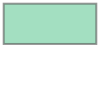

In [22]:
polygon_from_bounds(geom.unary_union.bounds)

/tmp/ipykernel_7875/3303464484.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  valid_labels.iloc[[idx]].geometry.unary_union


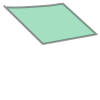

In [15]:
polygon_from_bounds(valid_labels.iloc[[idx]].geometry.unary_union

In [ ]:
import xarray as xr
ds = xr.open_dataarray('/code/data/ml_2021-08-01_2022-12-31_u0c.tif')
np.unique(ds.rio.clip(valid_labels.geometry).values)

In [63]:
with rasterio.open('/code/data/ml_2021-08-01_2022-12-31_u0c.tif') as src:
    result, transform = mask(src, [valid_labels.geometry], crop=True)

result

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



array([[[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0]]], dtype=int16)

<Axes: >

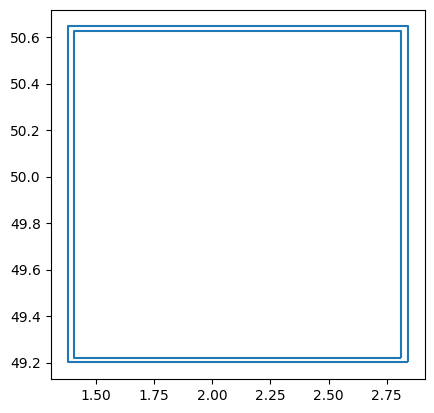

In [62]:
import xarray as xr
import rioxarray as rio
from shapely.geometry import box, Polygon
#fig, ax = plt.subplots(1,1, figsize=(12,12))



In [ ]:
ds = xr.open_dataarray("/code/data/ml_2021-08-01_2022-12-31_u0c.tif")
ds.to_dataframe()

In [48]:
valid_labels.buffer(0).unary_union.bounds

/tmp/ipykernel_875/1124354270.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  valid_labels.buffer(0).unary_union.bounds


(1.406299, 49.219171, 2.812499, 50.627008)

In [37]:
valid_labels_utm.geometry.unary_union.bounds

/tmp/ipykernel_875/1950175957.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  valid_labels_utm.geometry.unary_union.bounds


(383960.4519232723, 5451860.941070473, 486727.7836504717, 5609081.388698297)

In [38]:
vrt.transform

Affine(25.15402411011593, 0.0, 381836.7589501574,
       0.0, -25.15402411011593, 5611638.501946792)

In [23]:
chunk.shape

(10, 6435, 4251)

In [24]:
reprojected_predictions.shape

(6435, 4251)

In [26]:
np.unique(reprojected_predictions)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,
        30,  31, 255], dtype=int16)

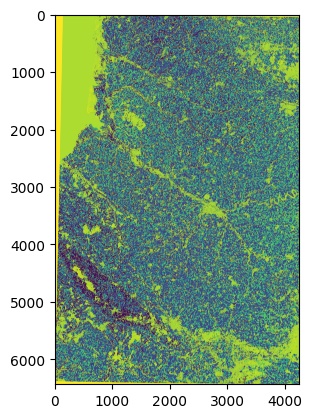

In [28]:
plt.imshow(reprojected_predictions, vmin=0, vmax=32)

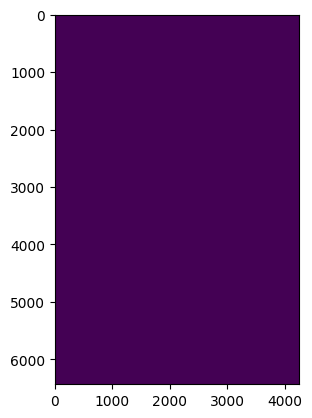

In [22]:
plt.imshow(chunk[2,:,:])

In [ ]:
annotation

# Diagnose confusion between crop types and propose a strategy to improve model performance.


# Implement efficient geospatial processing using Rasterio, Geopandas, and parallel computation.


# Provide a structured output and recommendations on how to enhance the training pipeline.
